In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
import tensorflow_datasets as tfds

from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import smart_resize
from keras.models import Model

2025-04-27 22:54:35.278349: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 22:54:35.294148: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 22:54:35.313269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745787275.338662   94249 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745787275.353220   94249 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745787275.425282   94249 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
from utils import convert_label_list, compute_anchors, produce_crop_list, compute_iou, matching_boxes_new, capture_background

## charger les données

In [3]:
training_dataset = tfds.load(
    "voc/2007",
    split="train",
    shuffle_files=False,
)
validation_dataset = tfds.load(
    "voc/2007",
    split="validation",
    shuffle_files=False,
)
test_dataset = tfds.load(
    "voc/2007",
    split="test",
    shuffle_files=False,
)
len(training_dataset), len(validation_dataset), len(test_dataset)

2025-04-27 22:54:37.847973: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


(2501, 2510, 4952)

## We need to create class background if we want to distinguish object from background

Format: [x_min, y_min, x_max, y_max]

Format: [x_topleft, y_topleft, x_bottomright, y_bottomright]

on doit : resize les images,
resize les coordonnées des bbox,
les labels = les numeros de labels, 
etiquettes 
et coordonnées des bbox

In [4]:
with open("/home/zuko39/tensorflow_datasets/voc/2007/4.0.0/labels.labels.txt") as file:
    lignes = [line.rstrip() for line in file]
indexes = [i for i in range(len(lignes))]
zip_label_line = zip(indexes, lignes)
d = dict(zip_label_line)

for i, j in d.items():
    print(i, j)

0 aeroplane
1 bicycle
2 bird
3 boat
4 bottle
5 bus
6 car
7 cat
8 chair
9 cow
10 diningtable
11 dog
12 horse
13 motorbike
14 person
15 pottedplant
16 sheep
17 sofa
18 train
19 tvmonitor


2025-04-27 22:54:38.045561: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


data cléées: dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects'])
tf.Tensor([12 14], shape=(2,), dtype=int64)
tf.Tensor([12 14 12 14], shape=(4,), dtype=int64)


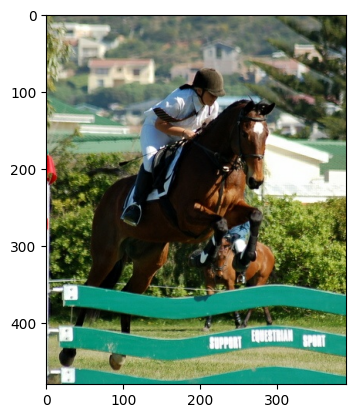

In [5]:
for data in training_dataset:#.shuffle(len(training_dataset)): #for one img
    print(f"data cléées: {data.keys()}")
    print(data['labels'])
    plt.imshow(data['image'])
    print(data['objects']['label'] )
    break

data cléées: dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects'])
data.objects cléées:dict_keys(['bbox', 'is_difficult', 'is_truncated', 'label', 'pose']), <class 'dict_keys'>
data.objects.label:[13 14], <class 'tensorflow.python.framework.ops.EagerTensor'>

data.objects.bbox:[[0.36253777 0.174      0.8791541  0.658     ]
 [0.11480363 0.29       0.8761329  0.61      ]], <class 'tensorflow.python.framework.ops.EagerTensor'>


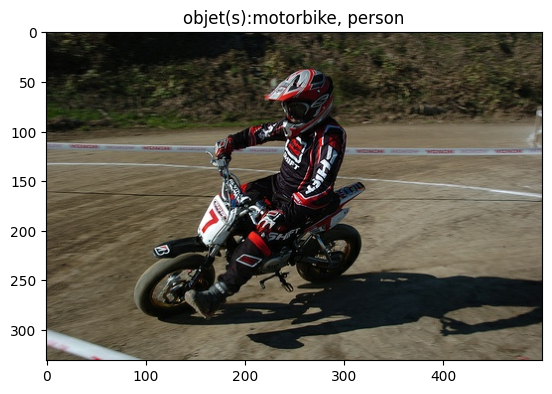

In [6]:
for data in training_dataset.shuffle(len(training_dataset)): #for one img
    print(f"data cléées: {data.keys()}")
    print(f"data.objects cléées:{data['objects'].keys()}, {type(data['objects'].keys())}")
    print(f"data.objects.label:{data['objects']['label']}, {type(data['objects']['label'])}") #returns a tensor listing the labels
    print()
    print(f"data.objects.bbox:{data['objects']['bbox']}, {type(data['objects']['bbox'])}")
    plt.imshow(data['image'])
    title = "objet(s):"
    for object in data['objects']['label']:
        title += f"{d[object.numpy()]}, "
    plt.title(title[:-2]);
    
    break

2025-04-27 22:54:41.226554: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


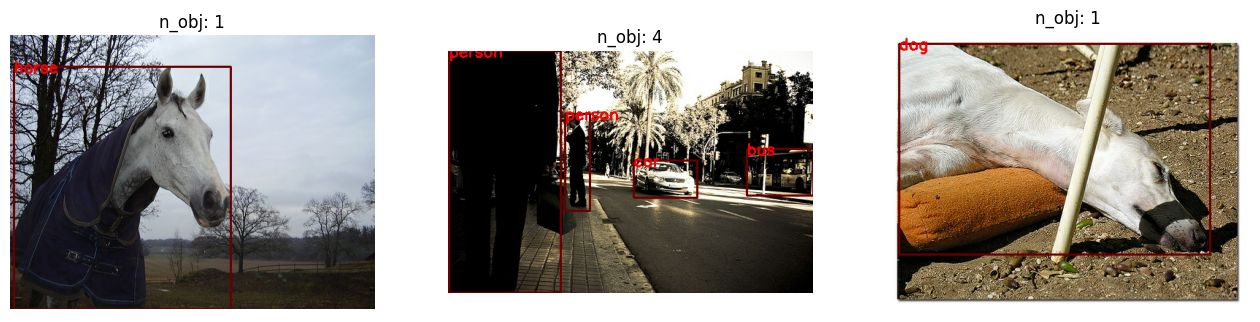

In [7]:
fig = plt.figure(figsize=(16, 10))

for idx, data in enumerate(training_dataset.shuffle(len(training_dataset)).take(3)): #for each 3 images
    fig.add_subplot(1, 3, idx+1)
    img = np.array(data['image'])
    y, x, _ = img.shape
    for idx2, objet in enumerate(data['objects']['label']): #for each object
        ymin, xmin, ymax, xmax = data['objects']['bbox'][idx2].numpy()
        im = cv2.rectangle(img, (int(xmin*x), int(ymin*y)), (int(xmax*x), int(ymax*y)), color=(105,0,0), thickness=2) #a rect for each objet
        etiquette = d[objet.numpy()] # add 1 so object corresponds to labels
        cv2.putText(im, etiquette, (int(xmin*x), int(ymin*y+8)), cv2.FONT_HERSHEY_SIMPLEX, .7, (235,5,5), 2)
    plt.axis("off")
    plt.title(f"n_obj: {len(data['objects']['label'])}")
    plt.imshow(img)

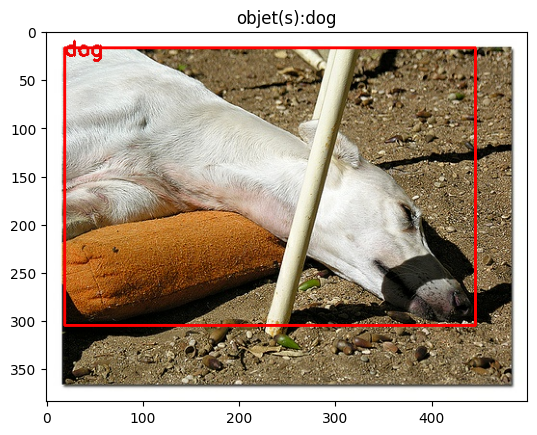

In [8]:
image = np.array(data['image'])
y, x, _ = image.shape
title = "objet(s):"

for index, objet in enumerate(data['objects']['label']): #for each object
    ymin, xmin, ymax, xmax = data['objects']['bbox'][index].numpy()
    img = cv2.rectangle(image, (int(xmin*x), int(ymin*y)), (int(xmax*x), int(ymax*y)), color=(255,0,0), thickness=2)
    cv2.putText(img, d[objet.numpy()], (int(xmin*x), int(ymin*y+8)), cv2.FONT_HERSHEY_SIMPLEX, .7, (235,5,5), 2)
    
    title += f"{d[objet.numpy()]}, "
plt.imshow(img)
plt.title(title[:-2]);

In [9]:
roi_pos_l = []
roi_neg_l = []

labels_pos = []
labels_back = []

liste_pos = [] #une liste de listes (matchs par images) en aura-t-on besoin plus tard?
liste_back = [] #une liste de listes (backg par images)

#on fait deux listes de listes : des sous listes par images avec les coord des gt bbox 
#et les coord des predictions pour pouvoir mesurer IoU et determiner si c'est des ROI positives ou negatives

for idx, data in enumerate(tqdm(training_dataset)): #for each image
    img = np.array(data['image'])
    y, x, _ = data['image'].shape
    roi = produce_crop_list(data['image'], compute_anchors(data['image'])) #list of predictions (tuples) for one img
    roi_coord = []
    gt_list_coord = []
    

    for _, roi_c in roi:
        roi_coord.append(roi_c)
        
    for idx2, objet in enumerate(data['objects']['bbox']): #for each object
        ymin_n, xmin_n, ymax_n, xmax_n = objet.numpy()
        bbox_gt= convert_label_list(ymin_n*y, xmin_n*x, ymax_n*y, xmax_n*x) #gt coord
        gt_list_coord.append(bbox_gt) #une liste de coord pour chaque objet

    pos = matching_boxes_new(roi_coord, gt_list_coord, 0.3) #une liste de matches pour une img
    back = capture_background(roi_coord, gt_list_coord, 0)
    
    if len(pos) > 0: #si on a un/+ match
        for p in pos:
            idx_tuple, iou, coord = p
            roi_pos = img.copy()[int(coord[1]-coord[3]/2):int(coord[1]+coord[3]/2),int(coord[0]-coord[2]/2):int(coord[0]+coord[2]/2)]
            roi_pos_l.append(cv2.resize(roi_pos, (224,224)))
            label = data['objects']['label'].numpy()[idx_tuple[1]]
            labels_pos.append(label) #on applatit la structure qui etait nested car les roi sont mtnt les examples
            
    if len(back) > 0: #si on a un background
        for b in back:
            _, _, c = b
            roi_neg = img.copy()[int(c[1]-c[3]/2):int(c[1]+c[3]/2),int(c[0]-c[2]/2):int(c[0]+c[2]/2)]
            roi_neg_l.append(cv2.resize(roi_neg, (224,224)))
            label_b = 20
            labels_back.append(label_b)
    
    liste_pos.append(pos) # pour chaque img, append liste des examples positifs
    liste_back.append(back)

  0%|          | 0/2501 [00:00<?, ?it/s]

2025-04-27 22:54:51.044050: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
d[20] = 'background' #on update le dict

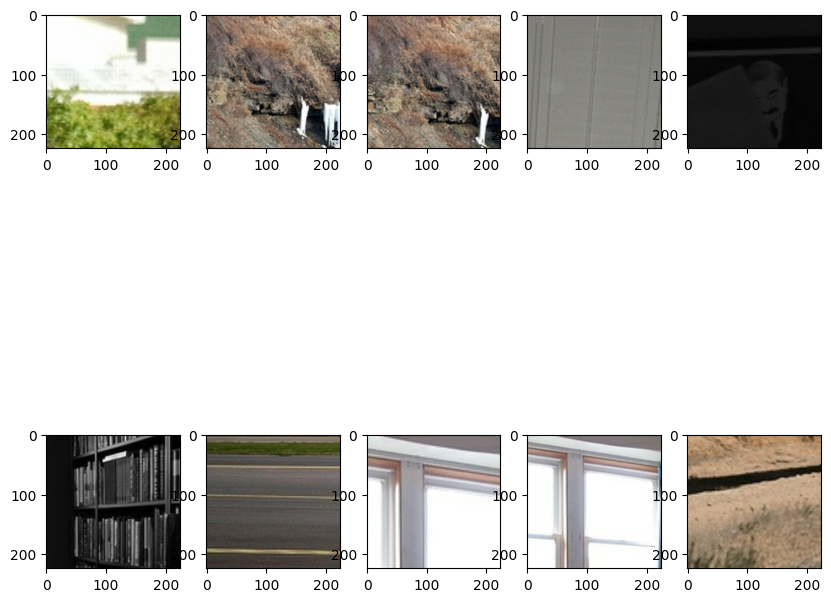

In [11]:
fig = plt.figure(figsize=(10, 10)) #exemples de background
for idx, i in enumerate(roi_neg_l[:10]):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(i)
plt.show()

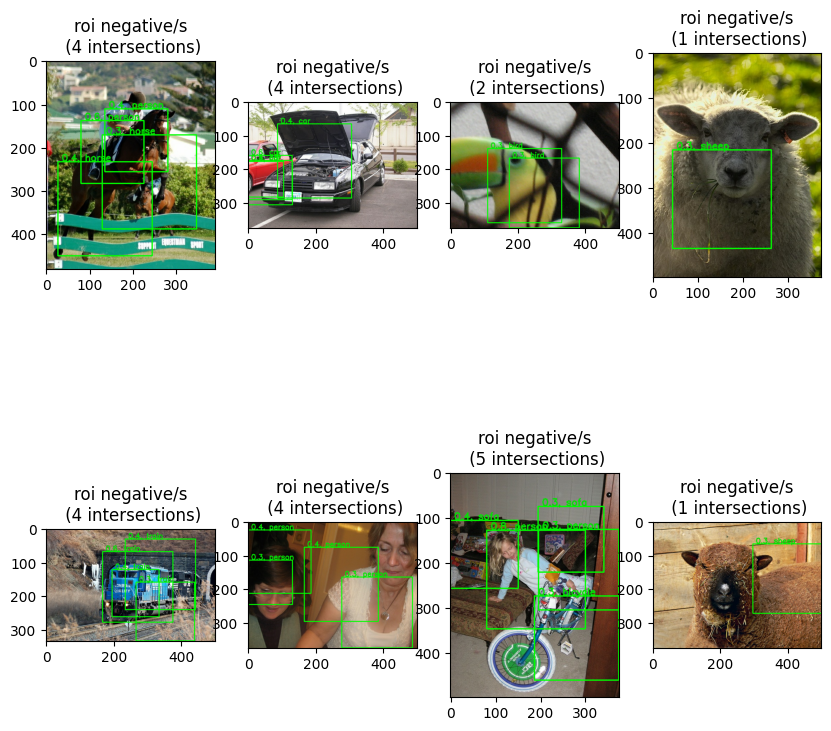

In [12]:
fig = plt.figure(figsize=(10, 10))
for idx, data in enumerate(training_dataset.take(8)):
    fig.add_subplot(2, 4, idx+1)
    copy3 = np.array(data['image']).copy()
    c = 0
    if len(liste_pos[idx]) > 0 :
        for idx2, objet in enumerate(liste_pos[idx]):
            inex, iou, coord = objet
            xmid, ymid, w, h = coord
            im = cv2.rectangle(copy3, (int(xmid - w/2), int(ymid - h/2)), (int(xmid + w/2), int(ymid + h/2)), color=(0,255,0), thickness=2)
            #le deuxieme indice du tuple inex retourne par matching_boxes() etait le rang du label
            cv2.putText(im, f"{np.round(iou,1)}, {d[data['objects']['label'].numpy()[inex[1]]]}", (int(xmid - w/2+9), int(ymid - h/2-2)), cv2.FONT_HERSHEY_SIMPLEX, .7, (5,225,5), 2)
            c += 1
        plt.title(f"roi negative/s\n ({c} intersections)")
        plt.imshow(im)

2025-04-27 22:54:52.527071: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


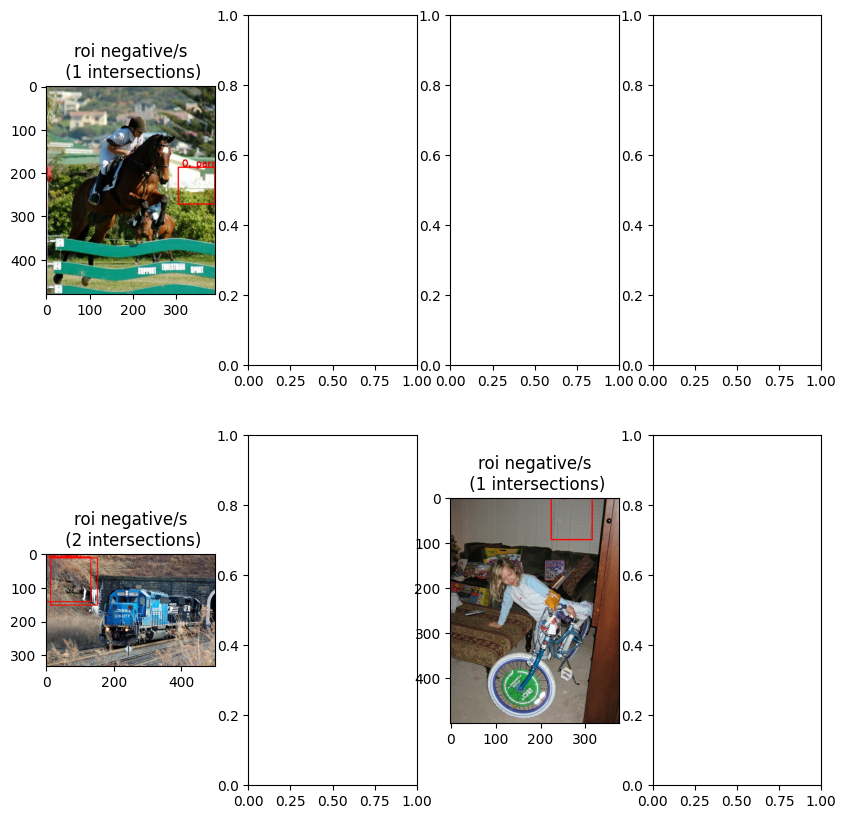

In [13]:
fig = plt.figure(figsize=(10, 10))
for idx, data in enumerate(training_dataset.take(8)):
    fig.add_subplot(2, 4, idx+1)
    copy3 = np.array(data['image']).copy()
    c = 0
    if len(liste_back[idx]) > 0 :
        for idx2, objet in enumerate(liste_back[idx]):
            inex, iou, coord = objet
            xmid, ymid, w, h = coord
            im = cv2.rectangle(copy3, (int(xmid - w/2), int(ymid - h/2)), (int(xmid + w/2), int(ymid + h/2)), color=(255,0,0), thickness=2)
            #le deuxieme indice du tuple inex retourne par matching_boxes() etait le rang du label
            cv2.putText(im, f"{iou}, {d[data['objects']['label'].numpy()[inex[1]]]}", (int(xmid - w/2+9), int(ymid - h/2-2)), cv2.FONT_HERSHEY_SIMPLEX, .7, (225,5,5), 2)
            c += 1
        plt.title(f"roi negative/s\n ({c} intersections)")
        plt.imshow(im)

In [14]:
liste_imgs = roi_pos_l + roi_neg_l
liste_labels = labels_pos + labels_back

In [15]:
d_size = 2048
batch_size = 8

In [16]:
# Identically shuffle the train and test datasets, récupéré d'un TP de RCP 209
if len(liste_imgs) == len(liste_labels):
    p = np.random.permutation(len(liste_imgs))
else:
    print('problem')

for idx, i in enumerate(p): #i is permutated indices that are iterated
    liste_imgs[idx] = liste_imgs[i]
    liste_labels[idx] = liste_labels[i]

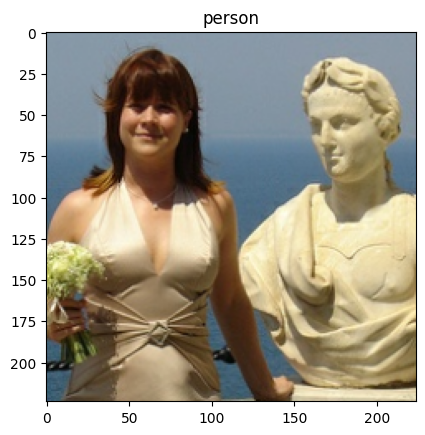

In [17]:
for i, j in zip(liste_imgs, liste_labels):
    plt.imshow(i)
    plt.title(f"{d[j]}")
    break

In [18]:
fraction = int(np.floor(len(liste_imgs)/4)) #on choisit 4 de manière empirique

ds_i = tf.data.Dataset.from_tensor_slices(np.array(liste_imgs[:fraction]))
ds_l = tf.data.Dataset.from_tensor_slices(liste_labels[:fraction])
ds = tf.data.Dataset.zip((ds_i, ds_l))
ds = ds.batch(batch_size)

In [19]:
dataset_i2 = tf.data.Dataset.from_tensor_slices(np.array(liste_imgs[fraction:2*fraction]))
dataset_l2 = tf.data.Dataset.from_tensor_slices(liste_labels[fraction:2*fraction])
ds2 = tf.data.Dataset.zip((dataset_i2, dataset_l2))
ds2 = ds2.batch(batch_size)

In [20]:
dataset = ds.concatenate(ds2)

## On fait le modèle

In [21]:
model = ResNet50(include_top=True, weights='imagenet')
model = Model(inputs=model.input, outputs=model.layers[-2].output) #on retire le classifieur de imagenet

## On entraîne le nouveau classifieur apres transfert par initialisation avec ImageNet

In [22]:
fc1 = layers.Dense(32, activation="relu")(model.output)
fc1 = keras.layers.Dropout(0.7)(fc1)
fc2 = Dense(21,activation='softmax')(fc1) #20 classes + back
model = Model(inputs=model.input, outputs=fc2)

for layer in model.layers[:-9]:
    layer.trainable = False
    
#recompile bc we changed the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy' ,
              metrics=['accuracy']
             )

#training

model.load_weights("/home/zuko39/envis/rcp_208/poids.weights.h5")

#model.fit(dataset, epochs=1)

/home/zuko39/envis/rcp_208/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
#model.save_weights("/home/zuko39/envis/rcp_208/poids.weights.h5", overwrite=True)

## On a une accuracy > 0.5 en train après 2 epochs avec un ResNet50 pre entrainé sur ImageNet
et dont seules les couches profondes aussi "hautes" ou plus que la dernière couche convolutive (conv5_block3_3_conv)
sont entraînées
on a fit tout le train set, on ne test pas les resultats sur un autre set de données car c'est seulement une étape intermédiaire

## Inférence

In [23]:
liste_detect = [] #une liste de listes 

for idx, data in enumerate(validation_dataset.take(25)): #for each image
    img = np.array(data['image'])
    y, x, _ = data['image'].shape
    #variable roi est doublet (img, coord_img)
    roi = produce_crop_list(data['image'], compute_anchors(data['image'])) #list of random rois for one img
    good_pred = [] # we prepare a list of good pred for each image
    for roi_img, roi_coord in roi: #pr chaque roi proposée
        final_pred = None
        pred = model.predict(smart_resize(roi_img,(224,224)).reshape(-1, 224, 224, 3)) #fr une pred pour chaque ROI
        rank = np.argmax(pred[0])
        for label, p in enumerate(pred[0]): #note pred lists labels in order
            if label != 20 and p > 0.25 and label == rank:
                final_pred = (p, label, roi_coord)
                good_pred.append(final_pred)
        else:
            pass
        
    liste_detect.append(good_pred) #chaque image a une liste de pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 

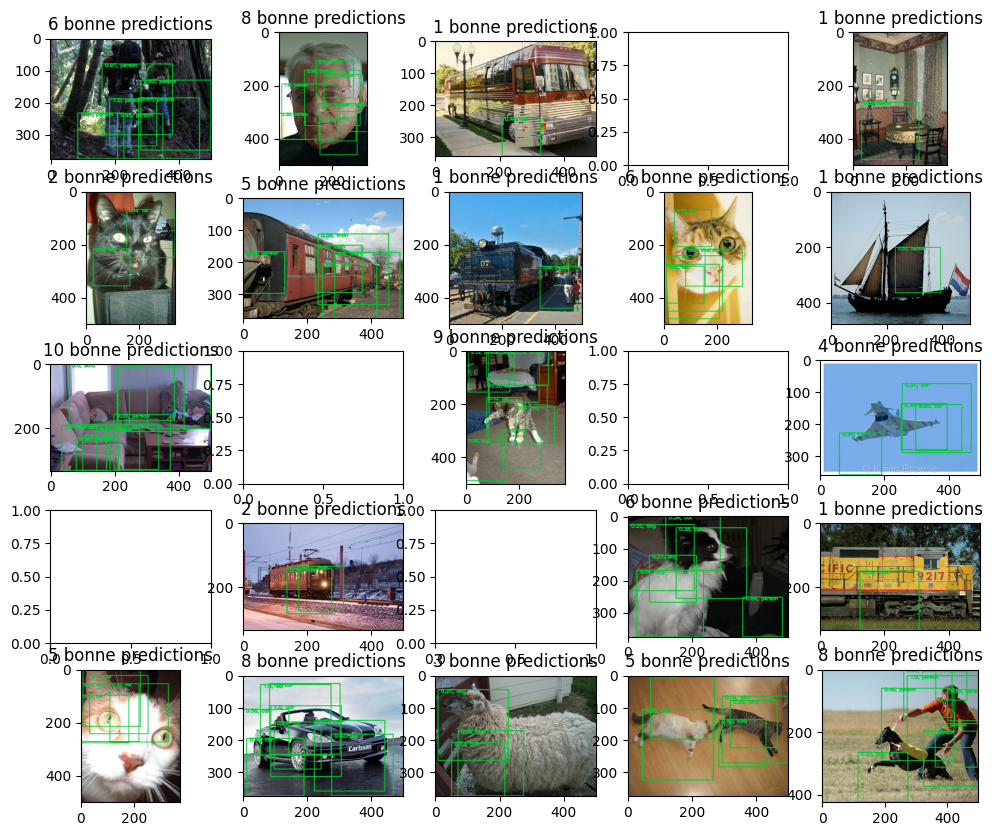

In [24]:
fig = plt.figure(figsize=(12, 10))
for idx, data in enumerate(validation_dataset.take(25)):
    copy3 = np.array(data['image']).copy()
    c = 0
    fig.add_subplot(5, 5, idx+1)
    if len(liste_detect[idx]) > 0 :
        for objet in liste_detect[idx]:
            proba, pred, coord = objet
            xmid, ymid, w, h = coord
            im = cv2.rectangle(copy3, (int(xmid - w/2), int(ymid - h/2)), (int(xmid + w/2), int(ymid + h/2)), color=(0,200,50), thickness=2)
            cv2.putText(im, f"{np.round(float(proba),2)}, {d[pred]}", (int(xmid - w/2+9), int(ymid - h/2+9)), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,205,55), 2)
            c += 1
        plt.title(f"{c} bonne predictions")
        plt.imshow(im);

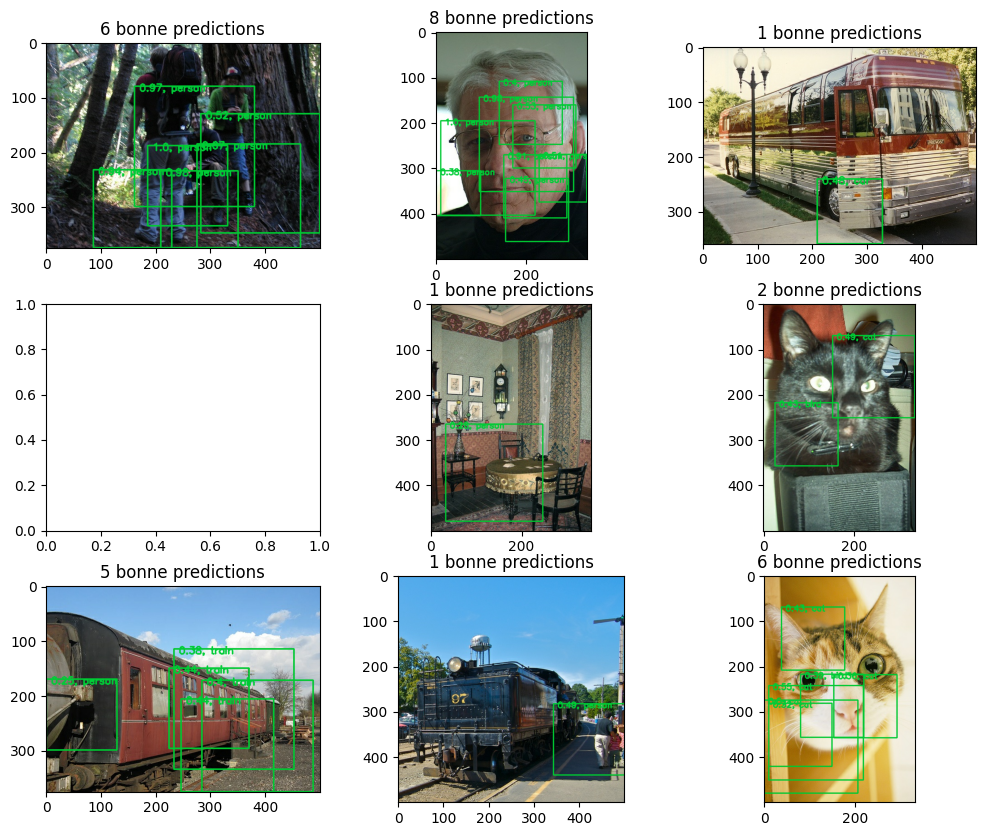

In [25]:
fig = plt.figure(figsize=(12, 10))
for idx, data in enumerate(validation_dataset.take(9)):
    copy3 = np.array(data['image']).copy()
    c = 0
    fig.add_subplot(3, 3, idx+1)
    if len(liste_detect[idx]) > 0 :
        for objet in liste_detect[idx]:
            proba, pred, coord = objet
            xmid, ymid, w, h = coord
            im = cv2.rectangle(copy3, (int(xmid - w/2), int(ymid - h/2)), (int(xmid + w/2), int(ymid + h/2)), color=(0,200,50), thickness=2)
            cv2.putText(im, f"{np.round(float(proba),2)}, {d[pred]}", (int(xmid - w/2+9), int(ymid - h/2+9)), cv2.FONT_HERSHEY_SIMPLEX, .6, (0,205,55), 2)
            c += 1
            plt.title(f"{c} bonne predictions")
            plt.imshow(im);

## Evaluation du modèle sur set de test
On fait une évaluation laxiste en construisant une métrique dérivée de l'AP mais différente

In [26]:
from utils import custom_recall

In [27]:
liste_d = [] #une liste de listes (autant de sous listes que d'images, len(sous listes) = nb_TP)
for data in tqdm(test_dataset.take(80)): #for each example
    img = np.array(data['image'])
    y, x, _ = data['image'].shape
    gt_labels = data['objects']['label'] #a list
    gt_boxes = data['objects']['bbox']
    
    gt_list = []
    for gt_label, gt_box in zip(gt_labels, gt_boxes): #for each gt object
        ymin_n, xmin_n, ymax_n, xmax_n = gt_box.numpy()
        bbox_gt= convert_label_list(ymin_n*y, xmin_n*x, ymax_n*y, xmax_n*x) #gt coord
        gt_list.append((gt_label, bbox_gt)) #list of tuples
    
    roi = produce_crop_list(data['image'], compute_anchors(data['image'])) #list of random rois for one img
    
    candidate_pred = []
    TP_list = []
    error = 0
    for roi_img, roi_coord in roi: #pr chaque roi proposée
        final_p = None
        pred = model.predict(smart_resize(roi_img,(224,224)).reshape(-1, 224, 224, 3)) #fr une pred pour chaque ROI
        rank = np.argmax(pred[0])
        for label, p in enumerate(pred[0]): # pr chaque pred Note prediction lists estimate probabilities in order of labels
            if label != 20 and p > 0.25 and label == rank:
                final_p = (label, roi_coord)
                candidate_pred.append(final_p) #list of tuples
    score = custom_recall(candidate_pred, gt_list)
    liste_d.append(score)

  0%|          | 0/80 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/ste

2025-04-27 23:01:50.495753: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
total = 0
for i in liste_d:
    total += i[0]
total/len(liste_d)

0.26457837301587295

Text(0.5, 1.0, "dimensions : ((1668, 2848), <class 'numpy.ndarray'>)")

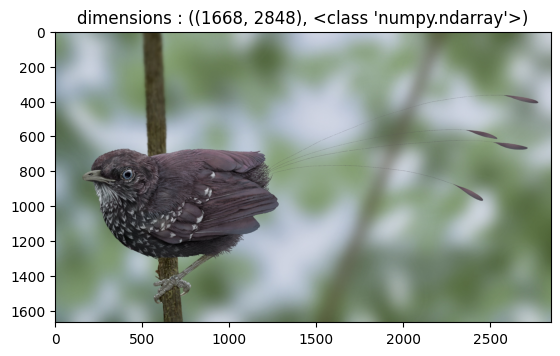

In [29]:
img_path = "Parvavis.jpg" 
image = cv2.imread(img_path)[...,::-1]
plt.imshow(image)
plt.title(f"dimensions : {image.shape[:2], type(image)}")

In [30]:
img = np.array(image)
y, x, _ = img.shape
#variable roi est doublet (img, coord_img)
roi = produce_crop_list(img, compute_anchors(img)) #list of random rois for one img
good_pred = [] # we prepare a list of good pred for each image
for roi_img, roi_coord in roi: #pr chaque roi proposée
    final_pred = None
    pred = model.predict(smart_resize(roi_img,(224,224)).reshape(-1, 224, 224, 3)) #fr une pred pour chaque ROI
    rank = np.argmax(pred[0])
    for label, p in enumerate(pred[0]): #note pred lists labels in order
        if label != 20 and p > 0.25 and label == rank:
            final_pred = (p, label, roi_coord)
            good_pred.append(final_pred)
    else:
        pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Text(0.5, 1.0, '3 bonne predictions')

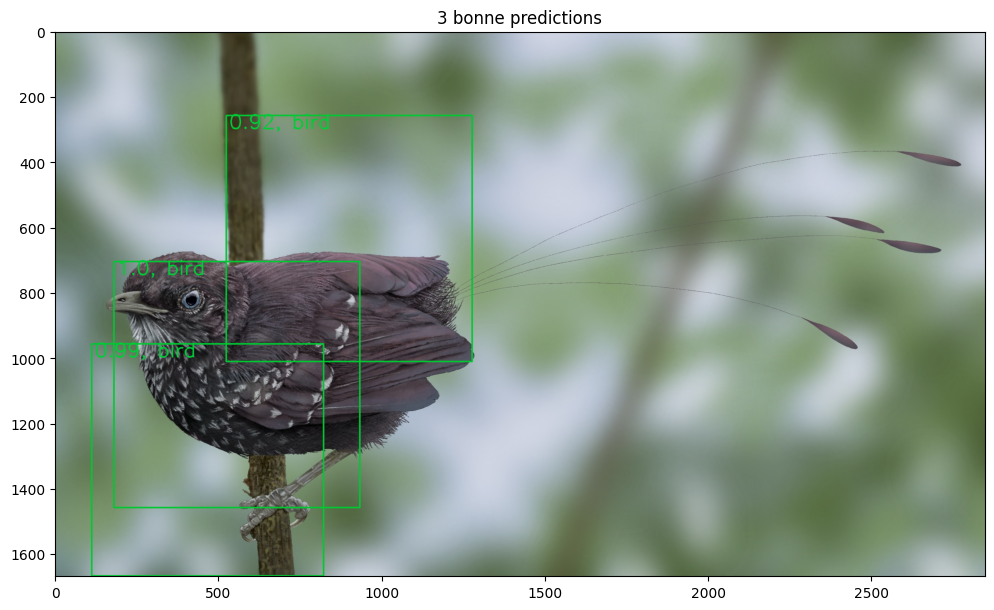

In [31]:
fig = plt.figure(figsize=(12, 10))
c = 0
for objet in good_pred:
    proba, pred, coord = objet
    xmid, ymid, w, h = coord
    im = cv2.rectangle(img, (int(xmid - w/2), int(ymid - h/2)), (int(xmid + w/2), int(ymid + h/2)), color=(0,200,50), thickness=4)
    cv2.putText(im, f"{np.round(float(proba),2)}, {d[pred]}", (int(xmid - w/2+9), int(ymid - h/2+40)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,205,55), 4)  
    c += 1
    plt.imshow(im);
plt.title(f"{c} bonne predictions")